## First Attempt at building a deepsets architecture

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp



#### Experimenting with input sizes

In [4]:
# For DECAM, BASS, MzLS
with open('../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

In [16]:
print(len(subpixel2ccd_dict))

28536897


In [17]:
min = 1000
max = 0
aggregate = 0
index_max = 0
lens = np.zeros(len(subpixel2ccd_dict))

for i,pix in enumerate(subpixel2ccd_dict.keys()):
    no_ccds = len(subpixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", max)
print("Min CCD's per subpixel:", min)



Mean CCD's per subpixel: 14.685108966122
Max CCD's per subpixel: 2978
Min CCD's per subpixel: 1


(array([26122277.,  2267658.,   107349.]),
 array([  0,  30,  50, 100]),
 <BarContainer object of 3 artists>)

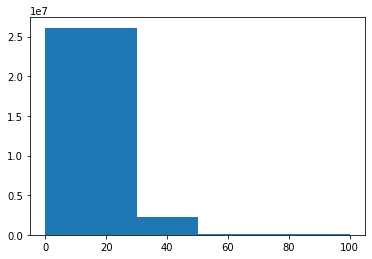

In [13]:
plt.hist(lens, bins=[0,30,50,100])


In [18]:
decamCCD = fits.open('../bricks_data/ccds-annotated-decam-dr9.fits')
mosaicCCD = fits.open('../bricks_data/ccds-annotated-mosaic-dr9.fits')
bassCCD = fits.open('../bricks_data/ccds-annotated-90prime-dr9.fits')
print(decamCCD[1].columns)


ColDefs(
    name = 'image_filename'; format = '120A'
    name = 'image_hdu'; format = 'I'
    name = 'camera'; format = '5A'
    name = 'expnum'; format = 'K'
    name = 'plver'; format = '8A'
    name = 'procdate'; format = '19A'
    name = 'plprocid'; format = '7A'
    name = 'ccdname'; format = '3A'
    name = 'object'; format = '35A'
    name = 'propid'; format = '10A'
    name = 'filter'; format = '1A'
    name = 'exptime'; format = 'E'
    name = 'mjd_obs'; format = 'D'
    name = 'airmass'; format = 'E'
    name = 'fwhm'; format = 'E'
    name = 'width'; format = 'I'
    name = 'height'; format = 'I'
    name = 'ra_bore'; format = 'D'
    name = 'dec_bore'; format = 'D'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'; format = 'E'
    name = 'crval1'; format = 'D'
    name = 'crval2'; format = 'D'
    name = 'cd1_1'; format = 'E'
    name = 'cd1_2'; format = 'E'
    name = 'cd2_1'; format = 'E'
    name = 'cd2_2'; format = 'E'
    name = 'yshift'; format = 'L'
    name = 

In [19]:
dataDecam = decamCCD[1].data
dataMosaic = mosaicCCD[1].data
dataBass = bassCCD[1].data

In [20]:
#ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
#print(len(ra0))
ra0_decam  = dataDecam.field('ra0')
ra0_mosaic = dataMosaic.field('ra0')
ra0_bass =dataBass.field('ra0')
print(len(ra0_decam) +  len(ra0_mosaic) + len(ra0_bass))

6776431


In [21]:
ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
dec0 = np.concatenate((dataDecam.field('dec0'), dataMosaic.field('dec0'), dataBass.field('dec0')), axis=0)

ra1 = np.concatenate((dataDecam.field('ra1'), dataMosaic.field('ra1'), dataBass.field('ra1')), axis=0)
dec1 = np.concatenate((dataDecam.field('dec1'), dataMosaic.field('dec1'), dataBass.field('dec1')), axis=0)

ra2 = np.concatenate((dataDecam.field('ra2'), dataMosaic.field('ra2'), dataBass.field('ra2')), axis=0)
dec2 = np.concatenate((dataDecam.field('dec2'), dataMosaic.field('dec2'), dataBass.field('dec2')), axis=0)

ra3 = np.concatenate((dataDecam.field('ra3'), dataMosaic.field('ra3'), dataBass.field('ra3')), axis=0)
dec3 = np.concatenate((dataDecam.field('dec3'), dataMosaic.field('dec3'), dataBass.field('dec3')), axis=0)



### Plotting the Pixel - CCD Relationship for the most populated pixel

In [ ]:
#Validating everything went as intended visually

NSIDE_SUB = 2048
pixel_number = index_max
# print(pixel2ccd_dict.keys())
print(len(subpixel2ccd_dict.keys()))


ccd = subpixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
#coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc],ra1[cc], ra2[cc], ra3[cc],ra0[cc] ]
    ys = [dec0[cc],dec1[cc], dec2[cc], dec3[cc],dec0[cc]]
    plt.plot(xs,ys)
#if i > 3:
    #break

pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(),lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0],pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1],pixel_boundary_raDec[1][0])


plt.plot(pixel_boundary_raDec[0],pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


## Building a deepsets architecture

In [3]:
# Import NN Packages
import torch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt


print(torch.__version__)


1.9.0


## Writing Dataset Utility to pass data in the right format

#### Steps:

1. Build a NN sampling an equal number of CCDs per 256 pixel and pass through deep sets for regression

2. Adapt NN for variable sized inputs

3. Adapt NN to use 64 layers of size 2048 to then predict density at 256

In [6]:
# Preparing Data to use
df = pd.read_csv('../../bricks_data/dataset_geometric.csv')



In [ ]:
class DensitySurvey(Dataset):
    def __init__(self, df, galaxy_type, scaler_in=None, scaler_out=None):
        self.data = df
        # Extracting Targets and Input
        self.target = self.data[galaxy_type].to_numpy(copy=True)
        self.input = self.data.drop(columns=['lrg','elg','qso']).to_numpy(copy=True)

        # Scaling, when scaler is passed (test-set) use the existing scaler
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        if self.scaler_in is None:
            self.scaler_in = preprocessing.MinMaxScaler()
            self.scaler_out = preprocessing.MinMaxScaler()
            self.input = self.scaler_in.fit_transform(self.input)
            self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        else:
            self.input = self.scaler_in.transform(self.input)
            self.target = self.scaler_out.transform(self.target.reshape(-1, 1))


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.tensor(self.target[idx]).float()
